In [876]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from keras.datasets import cifar10
from scipy.signal import convolve2d

In [877]:
# Convolutional Layer
class ConvLayer:
    def __init__(self, input_shape, kernel_shape):
        input_channels, input_rows, input_cols,  = input_shape
        filter_count, kernel_rows, kernel_cols = kernel_shape
        self.input_shape = input_shape
        self.kernel_shape = kernel_shape
        self.output_shape = (
            filter_count,
            input_rows - kernel_rows + 1,
            input_cols - kernel_cols + 1,
        )
        self.prev_input = None
        self.prev_output = None

        # Initialize filters with he initalization
        n_in = input_channels * kernel_rows * kernel_cols
        self.filters = np.random.randn(
            filter_count, input_channels, kernel_rows, kernel_cols
        ) * np.sqrt(2 / n_in)
        self.biases = np.zeros((filter_count, 1))

    def forward(self, input):
        input_count, input_channels, input_rows, input_cols = input.shape
        filter_count, kernel_rows, kernel_cols = self.kernel_shape
        output_channels, output_rows, output_cols = self.output_shape

        sample_count = input.shape[0]

        output = np.zeros((sample_count, *self.output_shape))

        for (input_sample, output_sample) in zip(input, output):
            for (filter, output_channel, bias) in zip(self.filters, output_sample, self.biases):
                for (input_channel, filter_channel) in zip(input_sample, filter):
                    output_channel += convolve2d(
                        input_channel, filter_channel, mode="valid"
                    )
                output_channel += bias
        
        self.prev_input = input
        self.prev_output = output
        return output

    def backward(self, output_error, learning_rate):
        pass

In [878]:
class MaxPoolLayer:
    def __init__(self, input_shape):
        input_channels, input_rows, input_cols = input_shape
        self.input_shape = input_shape
        self.output_shape = (
            input_channels,
            input_rows // 2 + input_rows % 2,
            input_cols // 2 + input_cols % 2,
        )
        self.prev_input = None
        self.select_mask = None
        self.prev_output = None

    def forward(self, input):
        output_depth, output_rows, output_cols = self.output_shape
        input_depth, input_rows, input_cols = self.input_shape

        batch_size = input.shape[0]
        output = np.zeros((batch_size, *self.output_shape))
        select_mask = np.zeros((batch_size, *self.input_shape))
        
        for sample in range(batch_size):
            for depth in range(input_depth):
                for row in range(0, input_rows, 2):
                    for col in range(0, input_cols, 2):
                        patch_index = np.argmax(input[sample, depth, row:row+2, col:col+2])
                        patch_row = patch_index // 2
                        patch_col = patch_index % 2
                        select_mask[sample, depth, row + patch_row, col + patch_col] = 1
                        output[sample, depth, row // 2, col // 2] = input[sample, depth, row + patch_row, col + patch_col]
        self.prev_input = input
        self.select_mask = select_mask
        self.prev_output = output
        return output
        
    def backward(self, output_error, learning_rate):
        # Upsample the output_error and then multiply by the select_mask

        def upsample(input):
            return input.repeat(2, axis=2).repeat(2, axis=3)
        
        upsampled_output_error = upsample(output_error)
        # Crop the upsampled_output_error to the size of the input (in case input is odd)
        upsampled_output_error = upsampled_output_error[:, :, :self.input_shape[1], :self.input_shape[2]]
        error = upsampled_output_error * self.select_mask
        return error


In [879]:
class FullyConnectedLayer:
    def __init__(self, input_shape, num_classifications):
        input_channels, input_rows, input_cols = input_shape
        self.input_shape = input_shape
        self.num_classifications = num_classifications

        # There will be no hidden layers
        # To stay consistent with the rust implementation, each column represents an observation
        # This means that for the weights, the number of rows is equal to the number of features

        # Initialize weights with he initalization
        self.weights = np.random.randn(
            num_classifications, input_channels * input_rows * input_cols
        ) * np.sqrt(2 / (input_channels * input_rows * input_cols))
        self.biases = np.zeros((num_classifications, 1))

        self.prev_input = None
        self.prev_output = None

    def flatten(self, input):
        batch_size = input.shape[0]
        return input.reshape(batch_size, -1)
    
    def softmax(self, input):
        maxes = np.max(input, axis=0)
        result = input - maxes
        result = np.exp(result)
        sums = np.sum(result, axis=0)
        return result / sums

    def forward(self, input):
        flattened_input = self.flatten(input).T #Also tranposes so that each column is an observation
        raw_output = self.weights.dot(flattened_input) + self.biases
        self.prev_input = flattened_input
        self.prev_output = self.softmax(raw_output)
        return self.prev_output

    def backward(self, output_error, learning_rate):
        # First do the error w.r.t the softmax output
        sample_count = output_error.shape[1]
        normalization_factor = 1.0 / sample_count

        db = output_error.sum(axis=1, keepdims=True)
        self.biases -= learning_rate * normalization_factor * db

        dw = output_error.dot(self.prev_input.T)
        self.weights -= learning_rate * normalization_factor * dw

        # Then do the error w.r.t the input
        output_error = self.weights.T.dot(output_error).T

        # Unflatten the output error
        output_error = output_error.reshape(sample_count, *self.input_shape)
        return output_error

In [880]:
class CNN:
    def __init__(self, input_shape, num_classifications):
        input_channels, input_rows, input_cols = input_shape
        self.input_shape = input_shape
        self.num_classifications = num_classifications
        self.layers = []
        self.accuracy = []
        self.loss = []
        self.curr_performance_info = (0, 1e-8, 0, 1) # (num_correct, loss, samples_processed, iter)

    def forward(self, input):
        layer_input = input
        for layer in self.layers:
            layer_input = layer.forward(layer_input)
        return layer_input

    def backward(self, output_error, learning_rate):
        layer_error = output_error
        for layer in reversed(self.layers):
            layer_error = layer.backward(layer_error, learning_rate)

    def update_performance_info(self, predictions, labels):
        batch_size = labels.shape[1]
        curr_iter = self.curr_performance_info[3]
        perf_interval = 50
        if curr_iter % perf_interval == 0:
            num_correct = self.curr_performance_info[0]
            loss = self.curr_performance_info[1]
            accuracy = num_correct / self.curr_performance_info[2]
            # print(f"Num Correct: {num_correct}, Loss: {loss}, Samples Processed: {self.curr_performance_info[2]}")
            print(f"Iteration {perf_interval * (len(self.accuracy)+1)} Accuracy: {accuracy}, Loss: {loss}")
            self.accuracy.append(accuracy)
            self.loss.append(loss)
            self.curr_performance_info = (0, 1e-8, 0, 0)
        
        # Calculate the number of correct predictions
        num_correct = np.sum(np.argmax(predictions, axis=0) == np.argmax(labels, axis=0))
        loss = -np.sum(labels * np.log(predictions + 1e-8)) / batch_size
        self.curr_performance_info = (self.curr_performance_info[0] + num_correct, self.curr_performance_info[1] + loss, self.curr_performance_info[2] + batch_size, self.curr_performance_info[3] + 1)

    def train(self, input, labels, learning_rate):
        predictions = self.forward(input)
        output_error = predictions - labels
        self.backward(output_error, learning_rate)
        self.update_performance_info(predictions, labels)

    def predict(self, input):
        return np.argmax(self.forward(input))

    def add_conv_layer(self, kernel_shape):
        prev_shape = (
            self.input_shape if len(self.layers) == 0 else self.layers[-1].output_shape
        )
        self.layers.append(ConvLayer(prev_shape, kernel_shape))

    def add_max_pool_layer(self):
        prev_shape = (
            self.input_shape if len(self.layers) == 0 else self.layers[-1].output_shape
        )
        self.layers.append(MaxPoolLayer(prev_shape))

    def add_fully_connected_layer(self):
        prev_shape = (
            self.input_shape if len(self.layers) == 0 else self.layers[-1].output_shape
        )
        self.layers.append(FullyConnectedLayer(prev_shape, self.num_classifications))

In [881]:
def one_hot_encode(y, num_classifications):
    encoded = np.zeros((y.size, num_classifications))
    for i in range(y.shape[0]):
        encoded[i][y[i]] = 1
    return encoded

In [882]:
def plot_accuracy_loss(cnn):
    # normalize the loss
    accuracy = cnn.accuracy
    loss = cnn.loss
    loss /= max(loss)
    perf_interval = 50

    # Create a list for the iterations
    x_ticks = list(range(50, (len(accuracy) + 1) * perf_interval, perf_interval))

    fig, ax = plt.subplots()
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Accuracy/Loss")
    ax.plot(x_ticks, accuracy, label="Accuracy")
    ax.plot(x_ticks, loss, label="Loss")

    ax.legend()
    plt.show()

In [883]:
# Lets load the dataset cifar-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Pull channels out so you have sample -> depth -> rows -> cols
x_train = x_train.transpose(0, 3, 1, 2)
x_test = x_test.transpose(0, 3, 1, 2)

# Load as numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 1)
(10000, 1)


In [884]:
# CNN with 2 CNN layers, 32x3x3 filters, 64x3x3 filters, max pool layer, fully connected layer
# 10 classifications
# 10 epochs
# 32 batch size

num_classifications = 10
input_width = 32
input_height = 32
input_channels = 3

cnn = CNN((input_channels, input_width, input_height), num_classifications)
# cnn.add_conv_layer((32, 3, 3))
# cnn.add_conv_layer((64, 3, 3))
cnn.add_max_pool_layer()
cnn.add_fully_connected_layer()

Iteration 50 Accuracy: 0.12244897959183673, Loss: 118.26886577006297
Iteration 100 Accuracy: 0.1525, Loss: 114.09683400101243
Iteration 150 Accuracy: 0.13, Loss: 115.07400159850228
Iteration 200 Accuracy: 0.165, Loss: 111.13228980664647
Iteration 250 Accuracy: 0.1975, Loss: 109.33161144150009
Iteration 300 Accuracy: 0.2225, Loss: 109.48582763961552
Iteration 350 Accuracy: 0.225, Loss: 106.92635824585784
Iteration 400 Accuracy: 0.265, Loss: 104.59839638015526
Iteration 450 Accuracy: 0.2375, Loss: 104.7640267150685
Iteration 500 Accuracy: 0.235, Loss: 105.1848721598263
Iteration 550 Accuracy: 0.2325, Loss: 103.96343293996264
Iteration 600 Accuracy: 0.24, Loss: 104.12395769351053
Iteration 650 Accuracy: 0.25, Loss: 102.49767151701808
Iteration 700 Accuracy: 0.2775, Loss: 102.29717690280614
Iteration 750 Accuracy: 0.24, Loss: 103.64678049579732


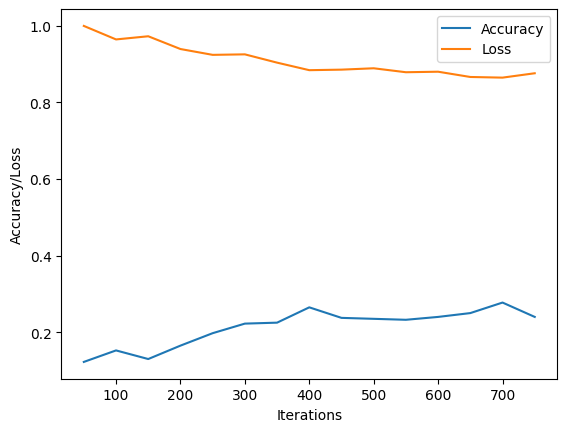

In [885]:
# Train the model
learning_rate = 0.01  # For now we will use stochastic gradient descent, not adam
batch_size = 8
epochs = 1

for epoch in range(epochs):
    # Shuffle the data
    indices = np.random.permutation(len(x_train))
    for i in range(0, len(x_train) // 8, batch_size):
        # Get the batch
        x_batch = x_train[indices[i : i + batch_size]]
        y_batch = y_train[indices[i : i + batch_size]]

        # Make sure labels are one hot encoded
        y_batch = one_hot_encode(y_batch, num_classifications)
        y_batch = y_batch.T

        # Train the model
        cnn.train(x_batch, y_batch, learning_rate)

plot_accuracy_loss(cnn)


Label: frog
Prediction: frog


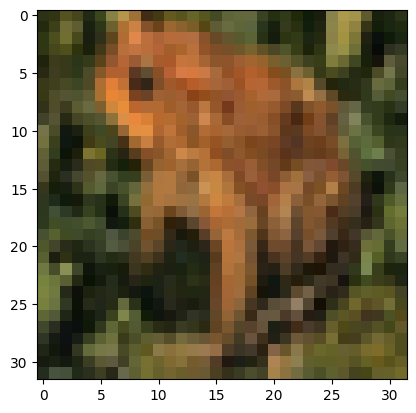

In [896]:
# Interactive test
index = np.random.randint(0, len(x_test))
input_as_batch = np.expand_dims(x_test[index], axis=0)
input_as_img = x_test[index].transpose(1, 2, 0)
label = y_test[index][0]
label_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
prediction = cnn.predict(input_as_batch)
print("Label:", label_names[label])
print("Prediction:", label_names[prediction] if prediction != None else "NONE")
plt.imshow(input_as_img)